In [ ]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
import numpy as np

In [ ]:
def preprocess_input(x):
    # Check if the image is grayscale
    if len(x.shape) == 2:
        # Convert grayscale to RGB
        x = cv2.cvtColor(x, cv2.COLOR_GRAY2RGB)

    # Normalization of pixel values to be in the range [-1, 1]
    x /= 127.5
    x -= 1.0

    return x

In [ ]:
BATCH_SIZE = 16

train_generator = ImageDataGenerator(validation_split=0.10,
                                     rotation_range=90,
                                     brightness_range=[0.7, 0.9],
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     preprocessing_function=preprocess_input)


test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data_dir = "./drive/MyDrive/Data/2ND_MODEL/train"
test_data_dir = "./drive/MyDrive/Data/2ND_MODEL/test"

In [ ]:
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 676 images belonging to 2 classes.
Found 74 images belonging to 2 classes.
Found 93 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications.nasnet import NASNetMobile

def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):

    conv_base = NASNetMobile(weights='imagenet',
                                input_shape=input_shape,
                                include_top=False)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.0001)
n_classes= 2

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 500

nasnetmobile_model = create_model(input_shape,
                                n_classes,
                                optim_1,
                                fine_tune=0)
nasnetmobile_model.summary()

94668760/94668760 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                             

In [ ]:
!pip install livelossplot

In [ ]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

path_model = './drive/MyDrive/Data/models/NasNetMobile.hdf5'

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath = path_model,
                                  save_best_only=True,
                                  verbose=1)

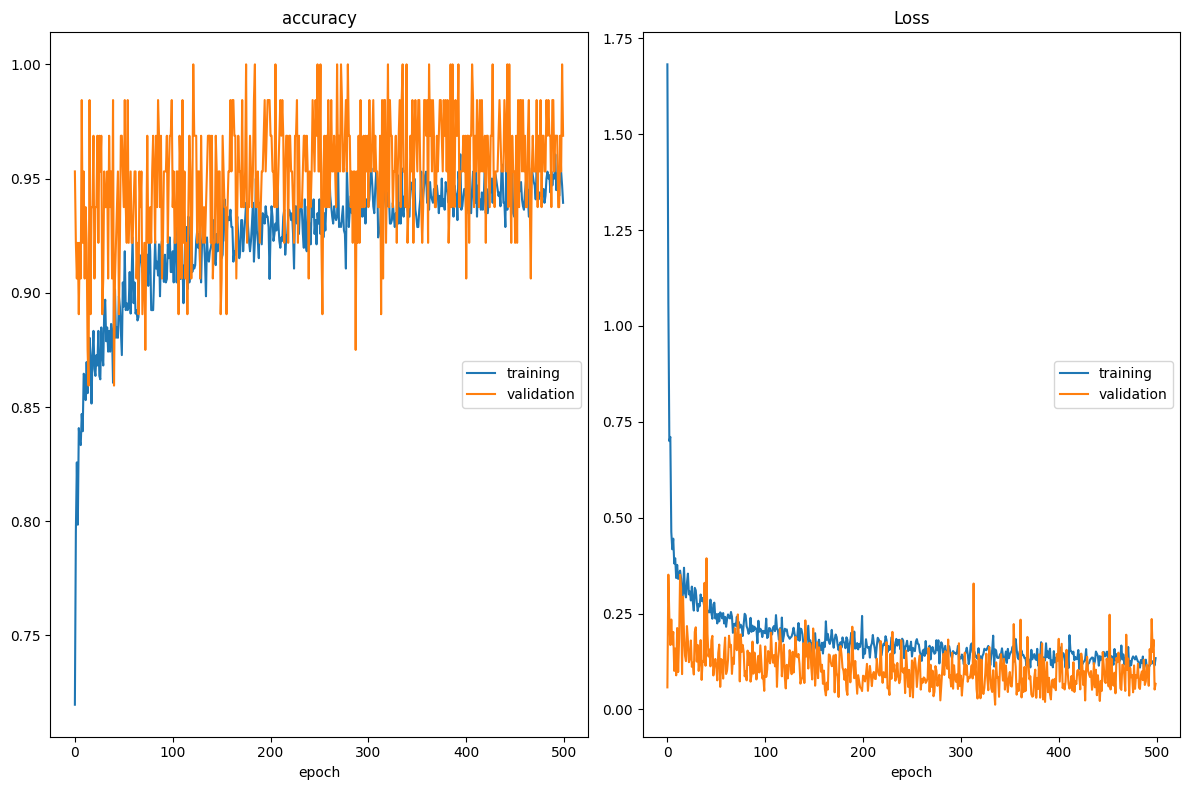

accuracy
	training         	 (min:    0.720, max:    0.961, cur:    0.939)
	validation       	 (min:    0.859, max:    1.000, cur:    0.969)
Loss
	training         	 (min:    0.100, max:    1.682, cur:    0.134)
	validation       	 (min:    0.012, max:    0.394, cur:    0.067)
42/42 [==============================] - 15s 351ms/step - loss: 0.1336 - accuracy: 0.9394 - val_loss: 0.0666 - val_accuracy: 0.9688
CPU times: user 1h 58min 18s, sys: 4min 11s, total: 2h 2min 29s
Wall time: 2h 33min 11s


In [ ]:
%%time

nasnetmobile_history = nasnetmobile_model.fit(traingen,
                                          batch_size=BATCH_SIZE,
                                          epochs=n_epochs,
                                          validation_data=validgen,
                                          steps_per_epoch=n_steps,
                                          validation_steps=n_val_steps,
                                          callbacks=[tl_checkpoint_1, plot_loss_1],
                                          verbose=1)

In [ ]:
# Generate predictions
nasnetmobile_model.load_weights(path_model) # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

nasnetmobile_preds = nasnetmobile_model.predict(testgen)
nasnetmobile_pred_classes = np.argmax(nasnetmobile_preds, axis=1)

93/93 [==============================] - 1s 11ms/step


In [ ]:
print(nasnetmobile_pred_classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
from sklearn.metrics import accuracy_score

nasnetmobile_acc = accuracy_score(true_classes, nasnetmobile_pred_classes)
print("NasNetMobile Model Accuracy: {:.2f}%".format(nasnetmobile_acc * 100))

NasNetMobile Model Accuracy: 95.70%


In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf
# Save the model to a TFLite file
# Load the HDF5 model
loaded_model = load_model(path_model)

converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()
path_tflite = "./drive/MyDrive/Data/model_tflite/NasNetMobile_model.tflite"

with open(path_tflite, "wb") as f:
    f.write(tflite_model)

In [ ]:
import os
import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import average_precision_score, classification_report
from sklearn.metrics import precision_recall_curve
from tensorflow.keras.preprocessing import image as tf_image

# Generate predictions
nasnetmobile_model.load_weights(path_model)  # Load the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v, k) for k, v in class_indices.items())

nasnetmobile_preds = nasnetmobile_model.predict(testgen)
nasnetmobile_pred_classes = np.argmax(nasnetmobile_preds, axis=1)

# Calculate precision, recall, and classification report
precision = precision_score(true_classes,
                            nasnetmobile_pred_classes,
                            average=None)

recall = recall_score(true_classes,
                      nasnetmobile_pred_classes,
                      average=None)

classification_report = classification_report(true_classes,
                                              nasnetmobile_pred_classes)

positive_precision = precision[1]  # Precision for positive class (class 1)
positive_recall = recall[1]  # Recall for positive class (class 1)

for class_index in range(n_classes):
    class_true = true_classes == class_index
    class_pred = nasnetmobile_preds[:, class_index]
    precision, recall, _ = precision_recall_curve(class_true, class_pred)
    avg_precision = np.mean(precision)


print("Precision: {:.2f}".format(positive_precision))
print("Recall: {:.2f}".format(positive_recall))
print("Classification Report:\n", classification_report)

93/93 [==============================] - 1s 12ms/step
Precision: 0.96
Recall: 0.93
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.91        34
           1       0.96      0.93      0.95        59

    accuracy                           0.94        93
   macro avg       0.93      0.94      0.93        93
weighted avg       0.94      0.94      0.94        93



In [ ]:
import tensorflow as tf

def get_flops(model_h5_path):
    session = tf.compat.v1.Session()
    graph = tf.compat.v1.get_default_graph()


    with graph.as_default():
        with session.as_default():
            model = tf.keras.models.load_model(model_h5_path)

            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

            # We use the Keras session graph in the call to the profiler.
            flops = tf.compat.v1.profiler.profile(graph=graph,
                                                  run_meta=run_meta, cmd='op', options=opts)

            return flops.total_float_ops

In [ ]:
estimated = get_flops(path_model)
print(estimated)

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


149675451


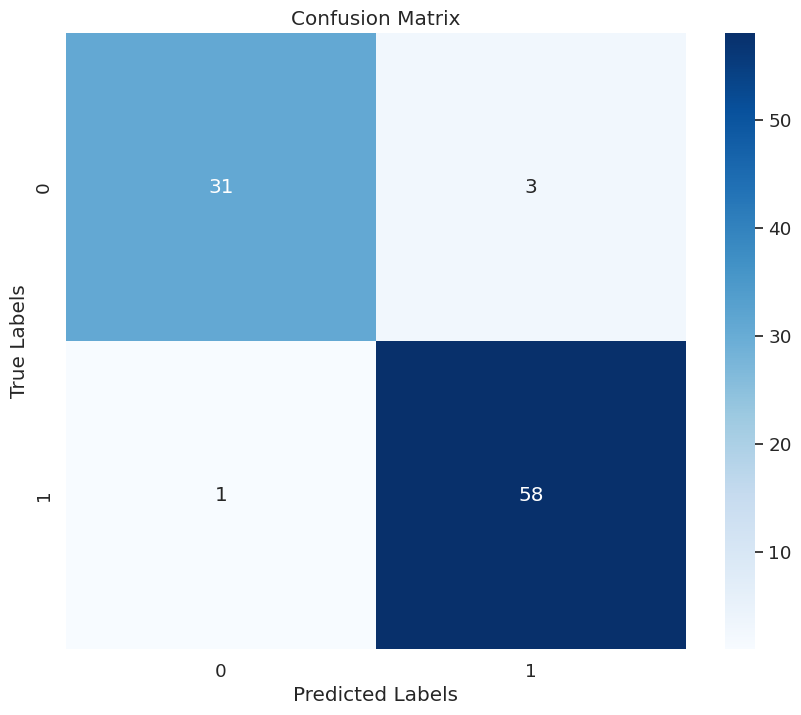

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(true_classes, nasnetmobile_pred_classes)

# Define class labels if needed
class_labels = [str(i) for i in range(cm.shape[0])]  # Assuming classes are indexed from 0 to n_classes-1

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # Adjust font scale if needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()